In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
loc = 'nw2'
turbine = 'c02'
mode = 'SS2'

In [6]:
# Initialize the folders
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')
data_folder

'c:\\Users\\Max\\Documents\\OWI_LAB\\Code\\DCE_EOVnorm\\dce_eov_normalisation\\data'

In [27]:
# GET THE DATA
# load the training data full
from src.data.make_dataset import create_input_target_dataset
inputs_training_full, ss2_training_full = create_input_target_dataset(data_folder, loc, turbine, mode)

#load the predictions of the training data
predictions_df_training = pd.read_parquet(os.path.join(data_folder, 'processed', loc, turbine+'_'+mode+'_mode_prediction_large_training.parquet'))
smart_tracked_modes_training = pd.read_parquet(os.path.join(data_folder, 'processed', loc, turbine+'_'+mode+'_smart_tracked_modes_large_training.parquet'))
case_IDS = pd.read_csv(os.path.join(data_folder, 'interim', loc,'labeled', loc+turbine+'_case.csv'))

# load the training data selected
selected_data_large = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
# Remove the selecyted data with duplicated timestamps and keep the one with the biggest size
selected_data_sorted = selected_data_large.sort_values(by='size', ascending=False)
selected_data_unique = selected_data_sorted.drop_duplicates(subset='timestamp', keep='first')
selected_data_unique = selected_data_unique.sort_values(by='timestamp')

# load the test data
test_data_path = '_'.join([loc, turbine, mode, 'test_data.parquet'])
test_turbine_data = pd.read_parquet(os.path.join(data_folder, 'raw', loc, test_data_path))


# load the data and the predictions of the test data
input_data_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'input.parquet'))
ss2_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'ss2.parquet'))
predictions_df_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'predictions.parquet'))
virtual_ensemble_preds_df_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'virtual_ensemble_predictions.parquet'))
smart_tracked_modes_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'smart_tracked_modes.parquet'))

dropped mvbc columns:  {'mvbc_WandelaarMeasuringpile_Relative_humidity', 'mvbc_WandelaarBuoy_Sea_water_temperature'}


In [28]:
case_IDS.set_index('timestamp', inplace=True)
case_IDS.index = pd.to_datetime(case_IDS.index) 

In [29]:
case_IDS.loc[predictions_df_training.index]
#replace caseID unique strings with integers
cases = {}
for i, case in enumerate(case_IDS['caseID'].unique()):
    case_IDS['caseID'].replace(case, i, inplace=True)
    cases[i] = case


In [39]:
cases

{0: nan,
 1: 'Rated RPM: Turbine rotating at 10.4rpm or 10.445rpm',
 2: 'rpm<Max: Turbine speeding up to rated RPM',
 3: 'rpm<6.6: Turbine rotating up to 6.6RPM',
 4: 'cutin (pitch 60): Turbine speeding up to operational speeds',
 5: 'pitch:78: Turbine pitched at 78deg.',
 6: 'rpm6.6: Turbine rotating at 6.6 RPM',
 7: 'cutin: Turbine speeding up to operational speeds',
 8: 'idling: Generic idling (no constraint on pitch)',
 9: 'parked: Turbine parked, pitched at >87, rotating at less than 0.4RPM',
 10: 'High wind: Turbine reducing output power at extreme wind speeds'}

Text(0, 0.5, 'residual')

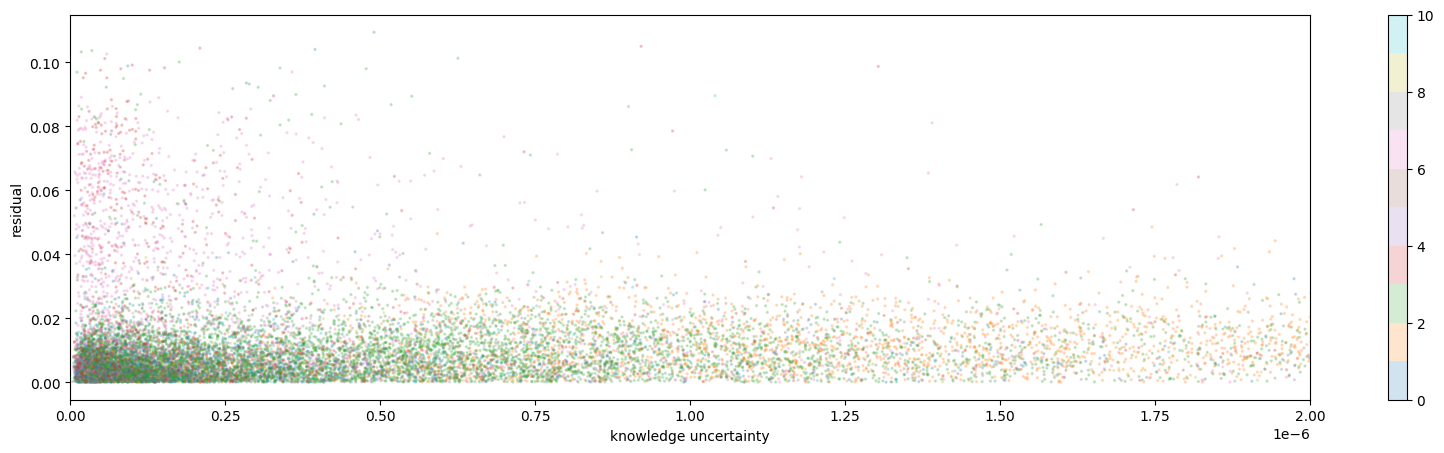

In [43]:
plt.figure(figsize=(20,5))
plt.scatter(predictions_df_training['knowledge_uncertainty'], np.abs(predictions_df_training['residual']),c=case_IDS.loc[predictions_df_training.index]['caseID'], label='training data', s=2, alpha = 0.2, cmap='tab10')
cbar = plt.colorbar()
cbar.set_alpha(1)
plt.xlabel('knowledge uncertainty')
plt.xlim(0,0.2*1e-5)
plt.ylabel('residual')